In [2]:
0.0004/4e-4

1.0

In [1]:
# %%timeit -n 5

import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats 
import scipy.optimize
import pandas as pd
import seaborn as sns

In [65]:
y=np.array([9.8e-4, 4.0e-4, 9.0e-4,3.4e-4])
y2=['with ucertainty','no uncertainty','with ucertainty','no uncertainty']

In [68]:
dff=pd.DataFrame([y,y2])

In [74]:
x=['1)M.C.(MysFunc. w/uncer)','2)M.C.(PM)','3)M.C.(PM w/uncer.)','4)FORM (PM)']

C:\Users\Usuario\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


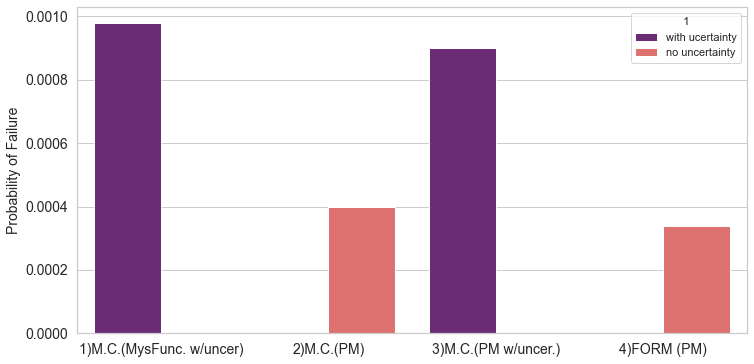

In [75]:
fig=plt.figure(figsize=(12,6))
sns.set_theme(style="whitegrid")
b=sns.barplot(x,dff.iloc[0],  hue=dff.iloc[1], palette='magma')
plt.ylabel('Probability of Failure', fontsize=14)
b.tick_params(labelsize=14)


## The following function estimates the 10-minute extreme blade root flapwise loads of a virtual wind turbine.

In [2]:
def MysteriousLoadFunc(X):
    import numpy as np
    Alsq = np.array([-8.49821625e+03,  3.21111941e+03, -3.44642937e+03, -8.33496535e+02,
       -2.28585769e+02,  7.27203251e+03,  9.25677112e+02,  1.16755478e+02,
        1.18918605e+03,  5.07954840e+00, -3.79944018e+03, -3.99715920e+01,
        7.18288327e+01, -1.82188802e+02, -2.61134584e+00, -2.53566886e+02,
        1.11035167e+03,  8.03450614e+00, -1.49376926e+02,  6.50965086e+00])

    X1 = X[:,0]
    X2 = X[:,1]
    X3 = X[:,2]
    X0 = np.ones(X1.shape)
    Xmatrix = np.array((X0,X1,X2,X3,X1**2,X2**2,X1*X2,X1*X3,X2*X3,X1**3,X2**3,(X1**2)*X2, (X1**2)*X3, \
                       (X2**2)*X1,(X2**2)*X3,X1*X2*X3, X2**4, (X1**2)*(X2**2), X2**5, X2**6)).T

    Y = np.dot(Xmatrix,Alsq) + 50e3 + np.random.randn(X0.shape[0])*4.0e3
    return Y

### Define function for Normal and LogNormal pdf, cdf and ppf.

In [3]:
def NormalDist(task,x,mu=0,sigma=1):
    import numpy as np
    if task == 0: # PDF
        y = (1.0/(sigma*np.sqrt(2.0*np.pi)))*np.exp(-((x - mu)**2)/(2.0*(sigma**2)))
    elif task == 1: # Cumulative
        from scipy.special import erf
        y = 0.5*(1.0 + erf((x - mu)/(sigma*np.sqrt(2))))
    elif task == 2: # Inverse
        from scipy.special import erfinv
        y = mu + sigma*np.sqrt(2)*erfinv(2*x - 1)        
    return y

# Helper functions - lognormal distribution
def LogNormDist(task,x,mu,sigma):
    import numpy as np
    Eps   = np.sqrt(np.log( 1.0+(sigma/mu)**2 ) )
    Ksi   = np.log(mu)-0.5*Eps**2
    if task == 0: # PDF
        x[x<=0] = 1e-8
        u =(np.log(x)-Ksi)/Eps
        y = np.exp(-u*u/2.0)/(Eps*x*np.sqrt(2.0*np.pi))
    elif task == 1: # Cummulative
        x[x<=0] = 1e-8
        u =(np.log(x)-Ksi)/Eps
        y= NormalDist(1, u)
    elif task == 2: # Inverse
        y= np.exp(Ksi+Eps*NormalDist(2, x))
    
    return y

## Define functions.

Turbulence ($\sigma$), Lognormal distributed.

In [4]:
MuSigmaFunc= lambda u: 0.14*(0.75*u + 3.8)
SigmaSigmaU=0.1657

Shear ($\alpha$), Normal distributed.

In [5]:
MuAlpha=0.1
def SigmaAlphaFunc(arr):
    sigmaAlpha=[]
    
    if type(arr)== np.ndarray:
        for u in arr:
            sigmaAlpha.append(min([1,1/u]))
        sigmaAlpha=np.asarray(sigmaAlpha)
    else:
        sigmaAlpha=min([1,1/arr])
    
    return sigmaAlpha

Material strength ($X_R$), Lognormal.

In [6]:
MuX_R=90e3
sigmaX_R=4.5e3

Stress uncertainty ($X_{str}$), Lognormal.

In [7]:
MuX_str=1
sigmaMuX_str=0.03

Blade geometry ($X_{geo}$), Lognormal.

In [8]:
MuX_geo=1
sigmaMuX_geo=0.03

## 1) Prepare a limit state equation which describes the state of the structure, using the original MysteriousLoadFunc.

In [9]:
N=100000
np.random.seed(100)
Fu=np.random.rand(N)
Aweib = 11.28
Kweib = 2
u = stats.weibull_min.ppf(Fu,c = Kweib,scale = Aweib)

In [10]:
muSigma = MuSigmaFunc(u)
sigmaSigma = SigmaSigmaU*np.ones(muSigma.shape)
Fsigma=np.random.rand(N)
sigmaU=LogNormDist(2,Fsigma,muSigma,sigmaSigma)

In [11]:
muAlpha = MuAlpha
sigmaAlpha = SigmaAlphaFunc(u)
Falpha = np.random.rand(N)
alpha = NormalDist(2,Falpha,muAlpha,sigmaAlpha)

In [12]:
WTS=np.concatenate([u.reshape(N,1),sigmaU.reshape(N,1),alpha.reshape(N,1)],axis=1)   #WTS stands for Wind, Turb and Shear.

In [13]:
S=MysteriousLoadFunc(WTS)

In [14]:
Fr,Fstr,Fgeo=np.random.rand(3,100000)
X_R,X_str,X_geo=LogNormDist(2,Fr,MuX_R,sigmaX_R),LogNormDist(2,Fstr,MuX_str,sigmaMuX_str), LogNormDist(2,Fgeo,MuX_geo,sigmaMuX_geo)

### Define limit state equation.

In [15]:
#input for the state limit equation.
X=[X_str*X_geo*X_R,S]

In [16]:
g=lambda X: X[0]-X[1] 

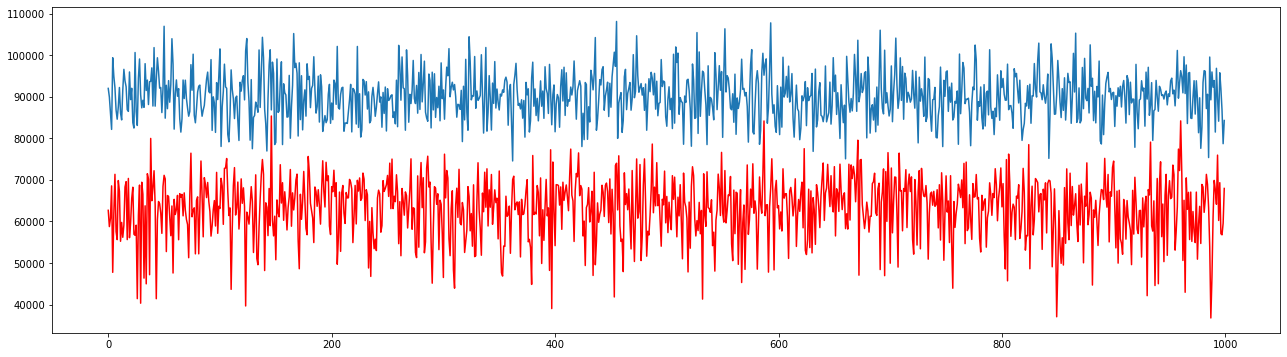

In [18]:
plt.figure(figsize=(22,6))
val=1000
plt.plot((X_str*X_geo*X_R)[:val])
plt.plot(S[:val], color='r')
plt.show()

In [34]:
df=pd.DataFrame(np.array(X).T, columns=['$X_{str}$ * $X_{geo}$ * $X_{R}$','$S$'])
df.head()

,$X_{str}$ * $X_{geo}$ * $X_{R}$,$S$
0,91993.548308,62667.365582
1,89922.250804,58749.726206
2,85851.445659,60736.594516
3,82132.293689,68540.889416
4,99373.352404,47744.269768


Text(0.5, 0, '[kN.M]')

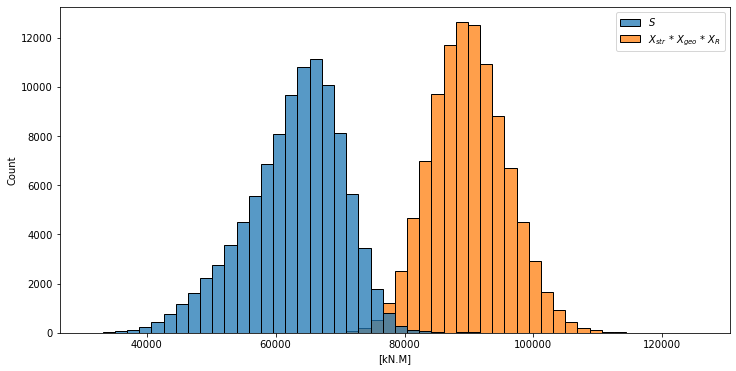

In [42]:
plt.figure(figsize=(12,6))
sns.histplot([df['$S$'],df['$X_{str}$ * $X_{geo}$ * $X_{R}$']],bins=50)
plt.xlabel('[kN.M]')

<AxesSubplot:ylabel='Count'>

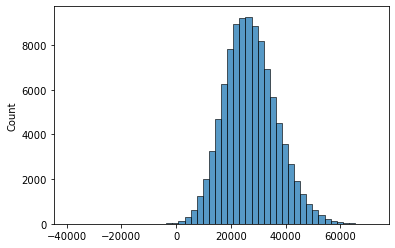

In [44]:
sns.histplot(df['$X_{str}$ * $X_{geo}$ * $X_{R}$']-df['$S$'],bins=50)

### Monte Carlo method for reliabilty index.

In [45]:
gMC0=g(X)

nfail=np.sum(gMC0 <=0)
pf_MC = (1/N)*np.sum(gMC0 <=0)
beta_MC = stats.norm.ppf(1-pf_MC)

In [47]:
print('Numb of failuer observations: ' +str(nfail))
print('Probability of failure - MC simulation: ' + str(pf_MC))
print('Reliability index - MC simulation: ' + str(beta_MC))

Numb of failuer observations: 98
Probability of failure - MC simulation: 0.0009800000000000002
Reliability index - MC simulation: 3.0962273801444082


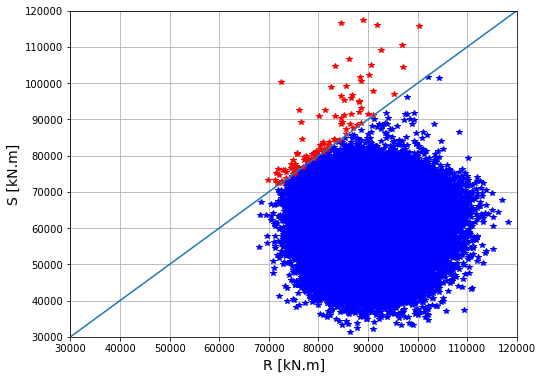

In [50]:
fig0,axs0 = plt.subplots(figsize = (8,6))

axs0.plot(X[0][gMC0 > 0],X[1][gMC0 >0],'*b')
axs0.plot(X[0][gMC0 <= 0],X[1][gMC0 <=0],'*r')
plt.ylabel('S [kN.m]',fontsize=14)
plt.xlabel('R [kN.m]',fontsize=14)
plt.plot([0,120000],[0,120000])
plt.ylim([30000,120000])
plt.xlim([30000,120000])
plt.grid()

## Polynomic model fitting.

In [53]:
Xmatrix = np.array([np.ones(u.shape), u**3, sigmaU**3, alpha**3, \
              (u**2)*sigmaU,(u**2)*alpha,(sigmaU**2)*u,(sigmaU**2)*alpha, \
              (alpha**2)*u, (alpha**2)*sigmaU, u*sigmaU*alpha, \
              u**2, sigmaU**2, alpha**2, u*sigmaU, u*alpha, sigmaU*alpha, \
              u, sigmaU, alpha]).T

PredictionFunc = lambda u,sigmaU,alpha,BetaCoef: np.dot(np.array([np.ones(u.shape), u**3, sigmaU**3, alpha**3, \
                                                           (u**2)*sigmaU,(u**2)*alpha,(sigmaU**2)*u,(sigmaU**2)*alpha, \
                                                           (alpha**2)*u, (alpha**2)*sigmaU, u*sigmaU*alpha, \
                                                           u**2, sigmaU**2, alpha**2, u*sigmaU, u*alpha, sigmaU*alpha, \
                                                           u, sigmaU, alpha]).T,BetaCoef)

In [54]:
InfoMatrix = np.dot(Xmatrix.T,Xmatrix) 
XY = np.dot(Xmatrix.T,S)  
Beta_fit = np.linalg.lstsq(InfoMatrix,XY,rcond = None)[0]
Y_fit = PredictionFunc(u,sigmaU,alpha,Beta_fit)
EpsilonErr_fit = S - Y_fit

Residual histogram.

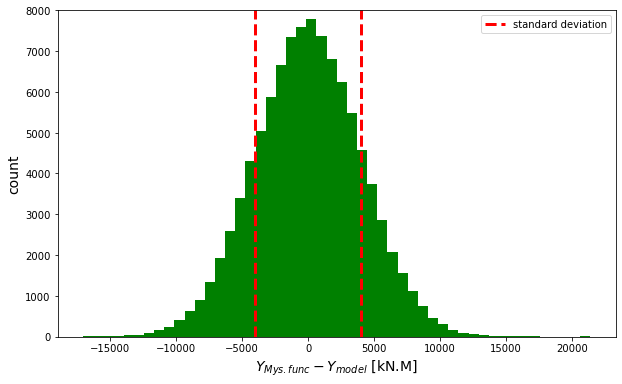

In [85]:
fig=plt.figure(figsize=(10,6))
plt.hist(EpsilonErr_fit,bins=50, color='green')
plt.plot([3997,3997],[0,8000], color='red', linestyle='--', linewidth=3, label='standard deviation')
plt.plot([-3997,-3997],[0,8000], color='red', linestyle='--', linewidth=3)
plt.xlabel('$Y_{Mys.func}-Y_{model}$ [kN.M]', fontsize=14)
plt.ylabel('count', fontsize=14)
plt.ylim([0,8000])
plt.legend()
plt.show()


In [56]:
EpsilonErr_fit.std()

3997.206439378712

In [57]:
X2=[X_str*X_geo*X_R,Y_fit]

gMC1=g(X2)

nfail=np.sum(gMC1 <=0)
pf_MC = (1/N)*np.sum(gMC1 <=0)
beta_MC = stats.norm.ppf(1-pf_MC)

In [58]:
print('Numb of failuer observations: ' +str(nfail))
print('Probability of failure - MC simulation: ' + str(pf_MC))
print('Reliability index - MC simulation: ' + str(beta_MC))

Numb of failuer observations: 40
Probability of failure - MC simulation: 0.0004
Reliability index - MC simulation: 3.3527947805048592


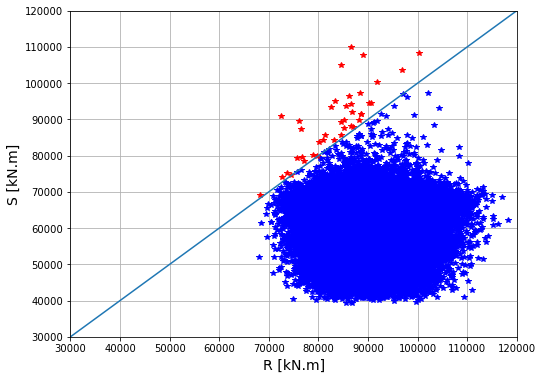

In [61]:
fig0,axs0 = plt.subplots(figsize = (8,6))
axs0.plot(X2[0][gMC1 > 0],X2[1][gMC1 >0],'*b')
axs0.plot(X2[0][gMC1 <= 0],X2[1][gMC1 <=0],'*r')
plt.ylabel('S [kN.m]',fontsize=14)
plt.xlabel('R [kN.m]',fontsize=14)
plt.plot([0,120000],[0,120000])
plt.ylim([30000,120000])
plt.xlim([30000,120000])
plt.grid()

Add uncertainty to the model and evalute the porbability of failer and reliability index again.

In [86]:
np.random.seed(100)
Y_fit_unc=Y_fit+np.random.randn(N)*4.0e3   # How does the uncertainty value affect the reliabilty index. 
#The 4.0e3 comes out from the Standard Deviation of the Residuals => EpsilonErr_fit.std()
X3=[X_str*X_geo*X_R,Y_fit_unc]

gMC=g(X3)

nfail=np.sum(gMC <=0)
pf_MC = (1/N)*np.sum(gMC <=0)
beta_MC = stats.norm.ppf(1-pf_MC)

print('Numb of failuer observations: ' +str(nfail))
print('Probability of failure - MC simulation: ' + str(pf_MC))
print('Reliability index - MC simulation: ' + str(beta_MC))

Numb of failuer observations: 90
Probability of failure - MC simulation: 0.0009000000000000001
Reliability index - MC simulation: 3.121389149359862


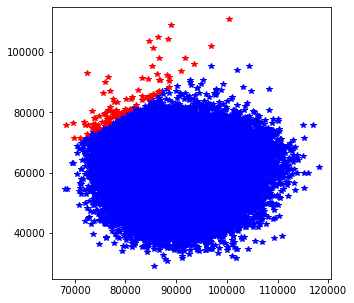

In [87]:
fig0,axs0 = plt.subplots(figsize = (5,5))
axs0.plot(X3[0][gMC > 0],X3[1][gMC >0],'*b')
axs0.plot(X3[0][gMC <= 0],X3[1][gMC <=0],'*r')

### FORM method.

In [ ]:
def rosenblatt(array):
    u=stats.norm.cdf(array)
    x0=stats.weibull_min.ppf(u[0],c = Kweib,scale = Aweib)
    
    muSigma = MuSigmaFunc(x0)
    ½sigmaSigma = SigmaSigmaU*np.ones(muSigma.shape)
    x1=LogNormDist(2,u[1],muSigma,sigmaSigma)
    
    muAlpha = MuAlpha
    sigmaAlpha = SigmaAlphaFunc(x0)
    x2 = NormalDist(2,u[2],muAlpha,sigmaAlpha)
    
    x3=LogNormDist(2,u[3],MuX_R,sigmaX_R) #X_R
    x4=LogNormDist(2,u[4],MuX_str,sigmaMuX_str) #X_str
    x5=LogNormDist(2,u[5],MuX_geo,sigmaMuX_geo) #X_geo
    
    return np.array([x0,x1,x2,x3,x4,x5])

In [ ]:
g=lambda X: X[3]*X[4]*X[5]-PredictionFunc(X[0],X[1],X[2],Beta_fit)
gradg01 = scipy.optimize.approx_fprime(u0,g,0.01)
gMyst= lambda X: X[3]*X[4]*X[5]-MysteriousLoadFunc(X[0],X[1],X[2])




In [ ]:
stop_iter = 1 #(initial value for the iteration)

u0 = np.array([0,0,0,0,0,0]) #1 starting point

itercount = 0
maxiter = 50
tol = 1e-4

ui = u0 # for the first iteration, take [0,0]           # 1)define start point.
betai = np.linalg.norm(u0)

In [ ]:
while stop_iter == 1:
    itercount+= 0
    
    #if itercount==0:
    F=stats.norm.cdf(ui) #compute the cumulative prob. for each value of ui   
    print('F: ',F)
    ui=rosenblatt(F)  #should reanme as X?
    print('X: ', ui)
        
    itercount+= 1    
    gi = g(ui)                                          # 2)calculate the limit state function for the given poinnt. 
    gradgi = scipy.optimize.approx_fprime(ui,g,0.01)  #gradg(ui)                                  # 3) calculate the gradient
    
    lambdai = (np.dot(gradgi.T,ui)- gi) / np.dot(gradgi.T, gradgi)
    ui_n = np.dot(lambdai, gradgi)                       # 4) Estimate an update for u_{i+1]  
    betai_n = np.sqrt(np.dot(ui_n.T, ui_n))              # 5) Update the reliability index
    
    epsilon = np.abs(betai_n-betai)                      # 6) Stop if |𝛽_𝑖+1 − 𝛽_𝑖| < 
    if epsilon <= tol:
        stop_iter = 0 
        print(f'entro 1, betai_n = {betai_n}, beta_i={betai}')
    elif itercount >= maxiter:
        stop_iter = 0
        print('entro 2')
    else:
        ui = ui_n  # update values to use in next iteration
        betai = betai_n
        print(f'entro 3')
        
beta_FORM = betai_n
pf_FORM = stats.norm.cdf(-beta_FORM)
u_star = ui_n
  
print('\t')
print('The analysis stopped after ' + str(itercount) + ' iterations.')
print('Probability of failure - FORM: ' + str(pf_FORM))
print('Reliability index - FORM: ' + str(beta_FORM))        

In [ ]:
stop_iter = 1 #(initial value for the iteration)

u0 = np.array([0,0,0,0,0,0]) #1 starting point

itercount = 0
maxiter = 50
tol = 1e-4

ui = u0 # for the first iteration, take [0,0]   
betai = np.linalg.norm(u0)

In [ ]:
while stop_iter == 1:
    itercount+= 1
    #g=gMyst
    gi = g(ui)  

    gradgi = scipy.optimize.approx_fprime(ui,g,0.01)  #gradg(ui)                                  # 3) calculate the gradient
    
    lambdai = (np.dot(gradgi.T,ui)- gi) / np.dot(gradgi.T, gradgi)
    ui_n = np.dot(lambdai, gradgi)                       # 4) Estimate an update for u_{i+1]  
    betai_n = np.sqrt(np.dot(ui_n.T, ui_n))              # 5) Update the reliability index
    
    epsilon = np.abs(betai_n-betai)                      # 6) Stop if |𝛽_𝑖+1 − 𝛽_𝑖| < 
    if epsilon <= tol:
        stop_iter = 0
    elif itercount >= maxiter:
        stop_iter = 0
    else:
        ui = ui_n  # update values to use in next iteration
        betai = betai_n
        
beta_FORM = betai_n
pf_FORM = stats.norm.cdf(-beta_FORM)
u_star = ui_n
        
print('The analysis stopped after ' + str(itercount) + ' iterations.')
print('Probability of failure - FORM: ' + str(pf_FORM))
print('Reliability index - FORM: ' + str(beta_FORM))  

### Optional task: if we have an uncertainty in the estimation of WIND SPEED PARAMETERS. What would be the effect of that uncertainty on the reliabilty? How can we take this into account in our reliabilty model?

In [ ]:
N=100000
np.random.seed(100)
Fu=np.random.rand(N)
Aweib = 11.28  #make Aweib a normal with some std dvt.
Kweib = 2
u = stats.weibull_min.ppf(Fu,c = Kweib,scale = Aweib)

In [ ]:
muSigma = MuSigmaFunc(u)
sigmaSigma = SigmaSigmaU*np.ones(muSigma.shape)
Fsigma=np.random.rand(N)
sigmaU=LogNormDist(2,Fsigma,muSigma,sigmaSigma)

In [ ]:
muAlpha = MuAlpha
sigmaAlpha = SigmaAlphaFunc(u)
Falpha = np.random.rand(N)
alpha = NormalDist(2,Falpha,muAlpha,sigmaAlpha)

In [ ]:
WTS=np.concatenate([u.reshape(N,1),sigmaU.reshape(N,1),alpha.reshape(N,1)],axis=1)

In [ ]:
plt.hist(u,bins=50)
plt.show()

In [ ]:
plt.hist(u+np.random.randn(N)*u.std(),bins=50)
plt.show()

In [ ]:
np.random.randn(N)*u.std()